In [1]:
using ForneyLab, Plots, LinearAlgebra, DelimitedFiles, DataFrames

In [2]:
#Generate data
using Random
import Distributions: pdf, MvNormal, rand

Random.seed!(1) # Set random seed

T = 40 # Number of timepoints

# Generative parameters
mu_0 = [8.0, 1.0] # Prior mean
V_0 = diagm(0=>ones(2)) # Prior covariance; diageye ensures an identity matrix of Diagonal type
F = [1.0 0.2; 
     -0.5 0.8] # Process matrix
H = [1.0 0.0; 
     0.0 1.0] # Observation matrix
Q = 1e-2*diagm(0=>ones(2)) # Process noise covariance
R = 1e-1*diagm(0=>ones(2)) # Observation noise covariance

# Data
x_hat = Vector{Vector{Float64}}(undef, T)
y_hat = Vector{Vector{Float64}}(undef, T)
prior_x = MvNormal(mu_0, V_0)
process_noise_dist = MvNormal(zeros(2), Q)
obs_noise_dist = MvNormal(zeros(2), R)

x_hat[1] = rand(prior_x)
y_hat[1] = H*x_hat[1] + rand(obs_noise_dist)
for t = 2:T
    x_hat[t] = F*x_hat[t-1] + rand(process_noise_dist) # Execute process
    y_hat[t] = H*x_hat[t] + rand(obs_noise_dist) # Draw observation
end
;

In [3]:
g = FactorGraph()

f(s,vec) = reshape(vec,(2,2))*s

# Pre-define vectors for storing latent and observed variables
x = Vector{Variable}(undef, T)
y = Vector{Variable}(undef, T)
mx = Vector{Variable}(undef, T-1)
a = Vector{Variable}(undef, T-1)

# Priors
@RV a_prior ~ GaussianMeanVariance(zeros(4),diagm(0=>ones(4)))
@RV x[1] ~ GaussianMeanVariance(mu_0, V_0)
@RV y[1] ~ GaussianMeanVariance(H*x[1], R) # Observation model
placeholder(y[1], :y, dims=(2,), index=1) # Indicate observed variable

for t = 2:T
    @RV a[t-1] ~ GaussianMeanVariance(a_prior, diagm(0=>1e-4*ones(4))) # to avoid loops
    @RV mx[t-1] ~ Nonlinear{Sampling}(x[t-1],a[t-1],g=f,dims=(2,))
    @RV x[t] ~ GaussianMeanVariance(mx[t-1], Q) # Process model
    @RV y[t] ~ GaussianMeanVariance(H*x[t], R) # Observation model

    placeholder(y[t], :y, dims=(2,), index=t) # Indicate observed variable
end
;

In [4]:
# Define posterior factorization
pfz = PosteriorFactorization()
q_a = PosteriorFactor(a_prior, id=:A)
q_x = Vector{PosteriorFactor}(undef, T)
for t=1:T
    q_x[t] = PosteriorFactor(x[t],id=:X_*t)
end

In [5]:
# Compile algorithm
algo_mf = messagePassingAlgorithm(id=:MF, free_energy=true)

# Generate source code
code_mf = algorithmSourceCode(algo_mf, free_energy=true);

In [6]:
# Load algorithm
eval(Meta.parse(code_mf))

# Initialize data
data = Dict(:y => y_hat)
n_its = 300

# Initial posterior factors
marginals_mf = Dict{Symbol, ProbabilityDistribution}()
marginals_mf[:a_prior] = ProbabilityDistribution(Multivariate, GaussianMeanVariance, m=zeros(4), v=diagm(0=>ones(4)))
for t = 1:T
    marginals_mf[:x_*t] = ProbabilityDistribution(Multivariate, GaussianMeanVariance, m=zeros(2), v=diagm(0=>ones(2)))
    if t != T
        marginals_mf[:mx_*t] = vague(SampleList, 2)
        marginals_mf[:a_*t] = ProbabilityDistribution(Multivariate, GaussianMeanVariance, m=zeros(4), v=diagm(0=>ones(4)))
    end
end

msgX = Vector{Vector{Message}}(undef, T)
for k=1:T-1
    msgX[k] = init(:MFX_*k)
end
msgX[T] = Vector{Message}(undef,6)

# Run algorithm
F_mf = Vector{Float64}(undef, n_its)
F_x = Vector{Float64}(undef, n_its)
for i = 1:n_its
    step!(:MFA, data, marginals_mf)
    
    for k = 1:T
        step!(:MFX_*k, data, marginals_mf, msgX[k])
    end
    if i == 50
        global F_est_50 = reshape(mean(marginals_mf[:a_prior]),(2,2))
    end
    F_mf[i] = freeEnergyMF(data, marginals_mf)
end
;

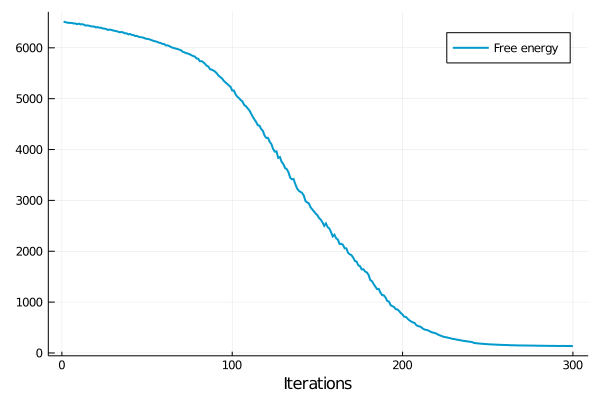

In [7]:
p = plot(F_mf, labels = "Free energy", color=:deepskyblue3, lw=2)
# ylabel!("Free energy")
xlabel!("Iterations")
png(p, "free-energy.png")
p

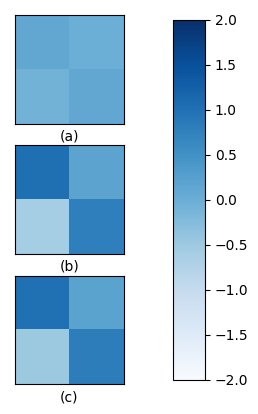

In [8]:
F_est = reshape(mean(marginals_mf[:a_prior]),(2,2))

using PyPlot
fig = figure()
g, axes = subplots(nrows=3, ncols=1)
fs = [F_est_50, F_est, F]
titles = ["(a)", "(b)", "(c)"]

im = nothing

for (i,ax) in enumerate(axes)
    im = ax.matshow(fs[i], cmap="Blues", vmin=-2.0, vmax=2.0)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xlabel(titles[i])
end

g.subplots_adjust(right=0.95)
ax = g.add_axes([0.7,0.12,0.05,0.75])
plt.colorbar(im, cax=ax);

PyPlot.savefig("estimates.png")

In [9]:
F_mf[end]

135.8369093617729